<a href="https://colab.research.google.com/github/cyclonecizek/MSDS-DTSA-5510-UnsupervisedLearning/blob/main/UnsupervisedSevere_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In this project, I explore the use of unsupervised learning techniques to identify distinct severe weather regimes using atmospheric sounding data collected at 1500Z/11:00am EDT from Cape Canaveral, Florida. Weather balloons launched at this time provide vertical profiles of the atmosphere, capturing a wide range of thermodynamic and kinematic variables that influence convective storm development. By filtering the data to focus on the warm season months (May through September) and isolating cases where severe weather was observed, I apply clustering algorithms to uncover patterns in the environmental conditions associated with different types of severe events. The goal is to characterize these regimes based on shared meteorological features, such as instability, wind shear, and moisture, and provide insight into the varying setups that can support severe convection in the central Florida region.

# Code Preamble

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from patsy import dmatrices

from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print("\n---Libraries loaded")



---Libraries loaded


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preproccessing/EDA

In [4]:
soundingfile = '/content/drive/My Drive/15Z_KXMR_soundingparameters.csv'
#plfile = '/content/drive/My Drive/precipltng_2008_2022.csv'
severe_reports = '/content/drive/My Drive/NWS_severe_reports_2008_2023.csv'
sounding_severe = '/content/drive/My Drive/sounding_severe_30nm_2005_2022.csv'
severe_days = '/content/drive/My Drive/severedates_30nm_2005_2023.csv'

In [5]:
df1 = pd.read_csv(soundingfile)
df2 = pd.read_csv(severe_days)
#df3 = pd.read_csv(severe_reports)


df2.head(10)
#print(df2.head(10))
#print(df3.head(10))

,Date,Severe
0,5/1/05,0
1,5/2/05,0
2,5/3/05,0
3,5/4/05,0
4,5/5/05,0
5,5/6/05,0
6,5/7/05,0
7,5/8/05,0
8,5/9/05,0
9,5/10/05,0


In [6]:
df1['Datetime'] = pd.to_datetime(df1[['Year', 'Month', 'Day']])

In [7]:
#only include rows that are in the months May through September, inclusive

df1 = df1[(df1['Month'] >= 5) & (df1['Month'] <= 9)]

In [8]:

df2['Date'] = pd.to_datetime(df2['Date'])

<ipython-input-8-feb01113be37>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Date'] = pd.to_datetime(df2['Date'])


In [9]:
df1 = df1[df1['Year'] >= 2005]

In [10]:
#Insert the df2[Severe] column to df1 where df1[Datetime] = df2[Date]

import pandas as pd
df1 = pd.merge(df1, df2[['Date', 'Severe']], left_on='Datetime', right_on='Date', how='left')
df1.drop('Date', axis=1, inplace=True)

In [11]:
#In each column header in df, remove the text that is in the parentheses, and the parentheses themselves

df1.columns = [col.split(' (')[0] for col in df1.columns]


In [12]:

columns = ['Platform', 'Year', 'Month', 'Elevation', 'Day', 'Hour', 'Minute', 'Sounding Base', 'Sounding Top', 'Sounding Levels', 'Bulk Richardson Number']
df1.drop(columns, inplace=True, axis=1)




df1.head(150)



,Lat,Lon,CAPE,700-500mb Lapse Rate,850-500mb Lapse Rate,LI,KI,Thompson Index,Total Totals,T 1000mb,T 850mb,T 700mb,T 500mb,Convective Temperature,1000-700mb RH,PWAT,700-500mb Average RH,Surface-700mb Average RH,Surface-700mb Average Wind Speed,1000-700mb Average U-Wind Component,1000-700mb Average V-Wind Component,1000-850mb Average U-Wind Component,1000-850mb Average V-Wind Component,850-700mb Average U-Wind Component,850-700mb Average V-Wind Component,850-500mb Average U-Wind Component,850-500mb Average V-Wind Component,850mb Average U-Wind Component,850mb Average V-Wind Component,700mb Average U-Wind Component,700mb Average V-Wind Component,500mb Average U-Wind Component,500mb Average V-Wind Component,250mb Average U-Wind Component,250mb Average V-Wind Component,0-6km Shear,0-3km Storm Relative Helicity,Wet Bulb Zero Level,Equilibrium Level,Lowest Freezing Level,-10C Level,Cloud Depth Ratio,Energy Helicity Index,Microburst Day Potential Index,WINDEX,Datetime,Severe
0,28.48,-80.55,651.067640,-0.001604,-0.001962,-2.7,32.6,35.3,44.4,23.8,18.2,4.6,-9.5,18.0,68.5,37.8,46.2,68.7,23.3,15.7,16.1,14.7,24.2,16.5,9.1,18.5,4.9,14.9,17.7,12.1,12.1,33.5,-5.9,50.8,18.5,38.915677,30.3,12526.2,NaN,14736.34853,19366.18336,NaN,0.123296,0.581552,4.976881,2005-05-01,0
1,28.48,-80.55,1236.944904,-0.001537,-0.001711,-2.5,31.1,33.6,44.8,21.8,14.6,4.0,-9.5,20.1,88.1,40.7,37.1,88.1,10.8,9.9,1.0,3.0,-1.4,15.9,3.1,24.0,4.2,5.0,-0.4,21.2,5.7,26.1,15.1,74.1,13.1,39.512584,-2.9,10876.7,38954.55671,12726.96723,19329.80422,0.307443,-0.022420,0.695409,9.944281,2005-05-02,0
2,28.48,-80.55,189.091421,-0.002120,-0.001889,-1.5,17.1,18.6,47.0,22.0,13.6,5.6,-12.9,14.6,56.2,29.4,33.8,56.6,14.2,10.5,0.3,-0.2,-1.8,19.7,2.1,21.7,2.8,13.9,-1.2,15.4,4.1,31.9,-8.6,62.0,16.6,52.522557,-9.5,8641.4,28383.60971,12647.99873,17866.63443,0.327136,-0.011227,0.591579,9.765966,2005-05-03,0
3,28.48,-80.55,1103.453883,-0.002068,-0.001841,-4.8,34.2,39.0,51.5,21.8,13.6,5.8,-12.3,19.9,90.7,44.4,51.7,90.6,16.1,3.3,9.5,-7.4,11.2,12.6,8.0,16.9,7.4,7.5,13.0,8.8,1.6,21.0,9.8,75.0,13.2,21.537747,179.8,11757.4,38818.31979,13874.07584,18271.56854,0.329787,1.240006,0.641265,3.611650,2005-05-04,0
4,28.48,-80.55,3118.066549,-0.001729,-0.001946,-8.1,37.8,45.9,50.3,22.8,15.2,3.0,-12.1,22.6,90.3,46.8,72.4,90.3,21.7,13.5,17.1,11.0,21.5,15.6,13.3,22.6,16.3,12.0,17.2,18.2,10.5,27.9,19.5,46.2,16.8,49.467737,90.9,11484.8,45726.02901,12375.46937,18224.71095,0.261205,1.771452,0.765858,12.613572,2005-05-05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,28.48,-80.55,0.000000,-0.001673,-0.001565,6.6,0.1,-6.5,35.6,NaN,16.8,9.4,-5.5,7.6,NaN,16.2,11.8,NaN,NaN,NaN,NaN,NaN,NaN,-12.0,3.5,-13.0,-1.2,-15.4,4.1,-11.9,-2.1,-11.5,-9.6,-10.0,-8.4,NaN,-14.7,10159.2,NaN,16158.13700,22165.37567,NaN,0.000000,0.348087,0.000000,2005-09-25,0
146,28.48,-80.55,192.129192,-0.001630,-0.001483,-1.8,9.6,11.4,37.3,26.0,15.4,8.8,-5.7,20.9,60.8,34.6,16.2,61.3,5.9,-1.0,4.8,-2.6,5.4,0.5,4.3,-4.2,4.3,1.9,-0.5,-4.4,2.5,-14.1,-5.1,-22.1,-15.5,13.826256,20.9,9204.1,28992.22538,16186.68575,21551.15917,0.518036,0.025097,1.004787,6.778153,2005-09-26,0
147,28.48,-80.55,1884.820066,-0.001868,-0.001771,-8.3,34.2,42.5,47.9,26.0,15.8,7.2,-9.3,23.6,83.0,46.1,46.0,82.9,11.8,0.1,11.4,-0.6,18.8,0.6,5.0,-1.3,6.3,1.7,4.8,-2.6,3.1,-5.4,15.0,-16.1,-19.2,-3.012952,-11.8,12848.9,NaN,14927.82200,19634.01728,NaN,-0.139005,1.047281,11.766430,2005-09-27,0
148,28.48,-80.55,1817.700652,-0.001902,-0.001863,-6.6,30.9,37.5,47.6,26.2,16.6,7.0,-9.7,21.6,78.1,45.2,50.1,78.0,7.6,-3.5,6.7,-4.2,6.6,-2.9,6.7,0.6,11.1,-5.1,7.3,-1.0,11.0,0.0,11.1,-10.6,-10.6,13.606880,-6.7,12059.8,NaN,13516.01093,19366.90105,NaN,-0.076116,1.107326,14.483296,2005-09-28,0


In [13]:
df1.drop(['Lat', 'Lon'], inplace=True, axis=1)

In [14]:
#make all the column names in df have no spaces within their string

df1.columns = [column.replace(' ', '_') for column in df1.columns]

In [15]:
df1.drop(['Datetime'], inplace=True, axis=1)
df1.drop(['Cloud_Depth_Ratio', 'Equilibrium_Level'], inplace=True, axis=1)

In [16]:
df1.info()
df1.describe()
df1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2789 entries, 0 to 2788
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CAPE                                 2710 non-null   float64
 1   700-500mb_Lapse_Rate                 2785 non-null   float64
 2   850-500mb_Lapse_Rate                 2784 non-null   float64
 3   LI                                   2722 non-null   float64
 4   KI                                   2783 non-null   float64
 5   Thompson_Index                       2722 non-null   float64
 6   Total_Totals                         2784 non-null   float64
 7   T_1000mb                             2617 non-null   float64
 8   T_850mb                              2784 non-null   float64
 9   T_700mb                              2785 non-null   float64
 10  T_500mb                              2785 non-null   float64
 11  Convective_Temperature        

,0
CAPE,79
700-500mb_Lapse_Rate,4
850-500mb_Lapse_Rate,5
LI,67
KI,6
...,...
-10C_Level,2
Energy_Helicity_Index,79
Microburst_Day_Potential_Index,7
WINDEX,117


In [17]:
df1.dropna(inplace = True)
df1.info()
df1.describe()
df1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 2447 entries, 0 to 2787
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CAPE                                 2447 non-null   float64
 1   700-500mb_Lapse_Rate                 2447 non-null   float64
 2   850-500mb_Lapse_Rate                 2447 non-null   float64
 3   LI                                   2447 non-null   float64
 4   KI                                   2447 non-null   float64
 5   Thompson_Index                       2447 non-null   float64
 6   Total_Totals                         2447 non-null   float64
 7   T_1000mb                             2447 non-null   float64
 8   T_850mb                              2447 non-null   float64
 9   T_700mb                              2447 non-null   float64
 10  T_500mb                              2447 non-null   float64
 11  Convective_Temperature             

,0
CAPE,0
700-500mb_Lapse_Rate,0
850-500mb_Lapse_Rate,0
LI,0
KI,0
...,...
-10C_Level,0
Energy_Helicity_Index,0
Microburst_Day_Potential_Index,0
WINDEX,0


In [18]:
df1['PWAT'] = df1['PWAT'].astype(float)
df1['PWAT'] = df1['PWAT']* 0.039370 # convert from mm to in
df1['PWAT'].describe()

,PWAT
count,2447.000000
mean,2.175288
std,22.537188
min,-7.732268
25%,1.488186
50%,1.767713
75%,1.976374
max,1115.438714


In [19]:
# Delete rows where 'PWAT' is < 0 or > 3 (not physically possible)
df1 = df1[(df1['PWAT'] >= 0) & (df1['PWAT'] <= 3)]
df1['PWAT'].describe()

,PWAT
count,2425.000000
mean,1.707322
std,0.382323
min,0.370078
25%,1.492123
50%,1.767713
75%,1.972437
max,2.925191


In [20]:
df1 = df1[(df1['WINDEX'] >= 0) & (df1['WINDEX'] <= 100)]
df1['WINDEX'].describe()

,WINDEX
count,2416.000000
mean,10.280335
std,5.363381
min,0.000000
25%,7.718574
50%,11.877071
75%,14.184919
max,21.490778


In [21]:
df_severe = df1[df1['Severe'] == 1]

In [22]:
df_severe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546 entries, 46 to 2787
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CAPE                                 546 non-null    float64
 1   700-500mb_Lapse_Rate                 546 non-null    float64
 2   850-500mb_Lapse_Rate                 546 non-null    float64
 3   LI                                   546 non-null    float64
 4   KI                                   546 non-null    float64
 5   Thompson_Index                       546 non-null    float64
 6   Total_Totals                         546 non-null    float64
 7   T_1000mb                             546 non-null    float64
 8   T_850mb                              546 non-null    float64
 9   T_700mb                              546 non-null    float64
 10  T_500mb                              546 non-null    float64
 11  Convective_Temperature             

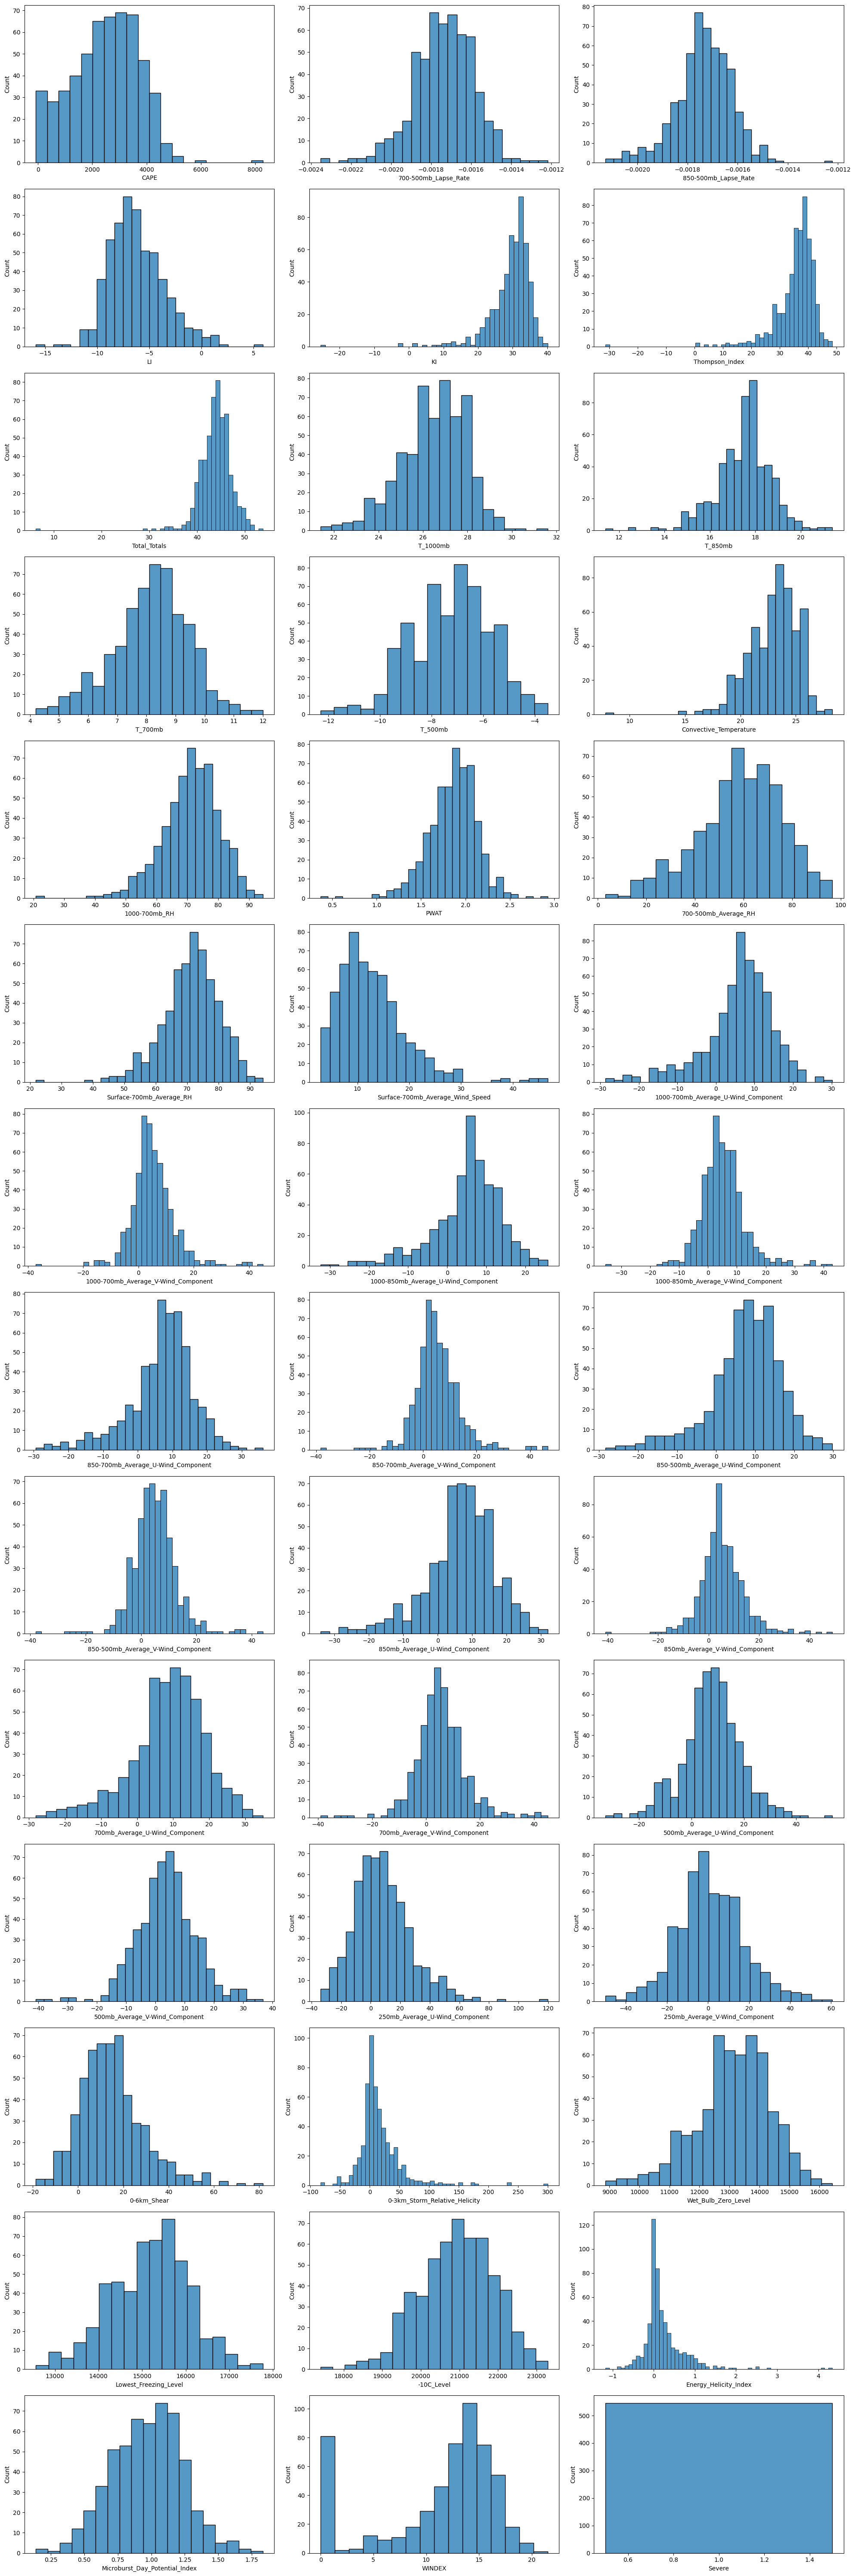

In [23]:
# Create figure and axes with 13 rows and 3 columns
fig, ax = plt.subplots(nrows=14, ncols=3, figsize=(20,60))

# Get the column names
distribution = df_severe.columns

rows = 0
cols = 0
for i, column in enumerate(distribution):
    # Use histplot instead of displot for better axes control
    sns.histplot(data=df_severe[column], ax=ax[rows, cols])
    cols += 1
    if cols == 3:
        cols = 0
        rows += 1

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

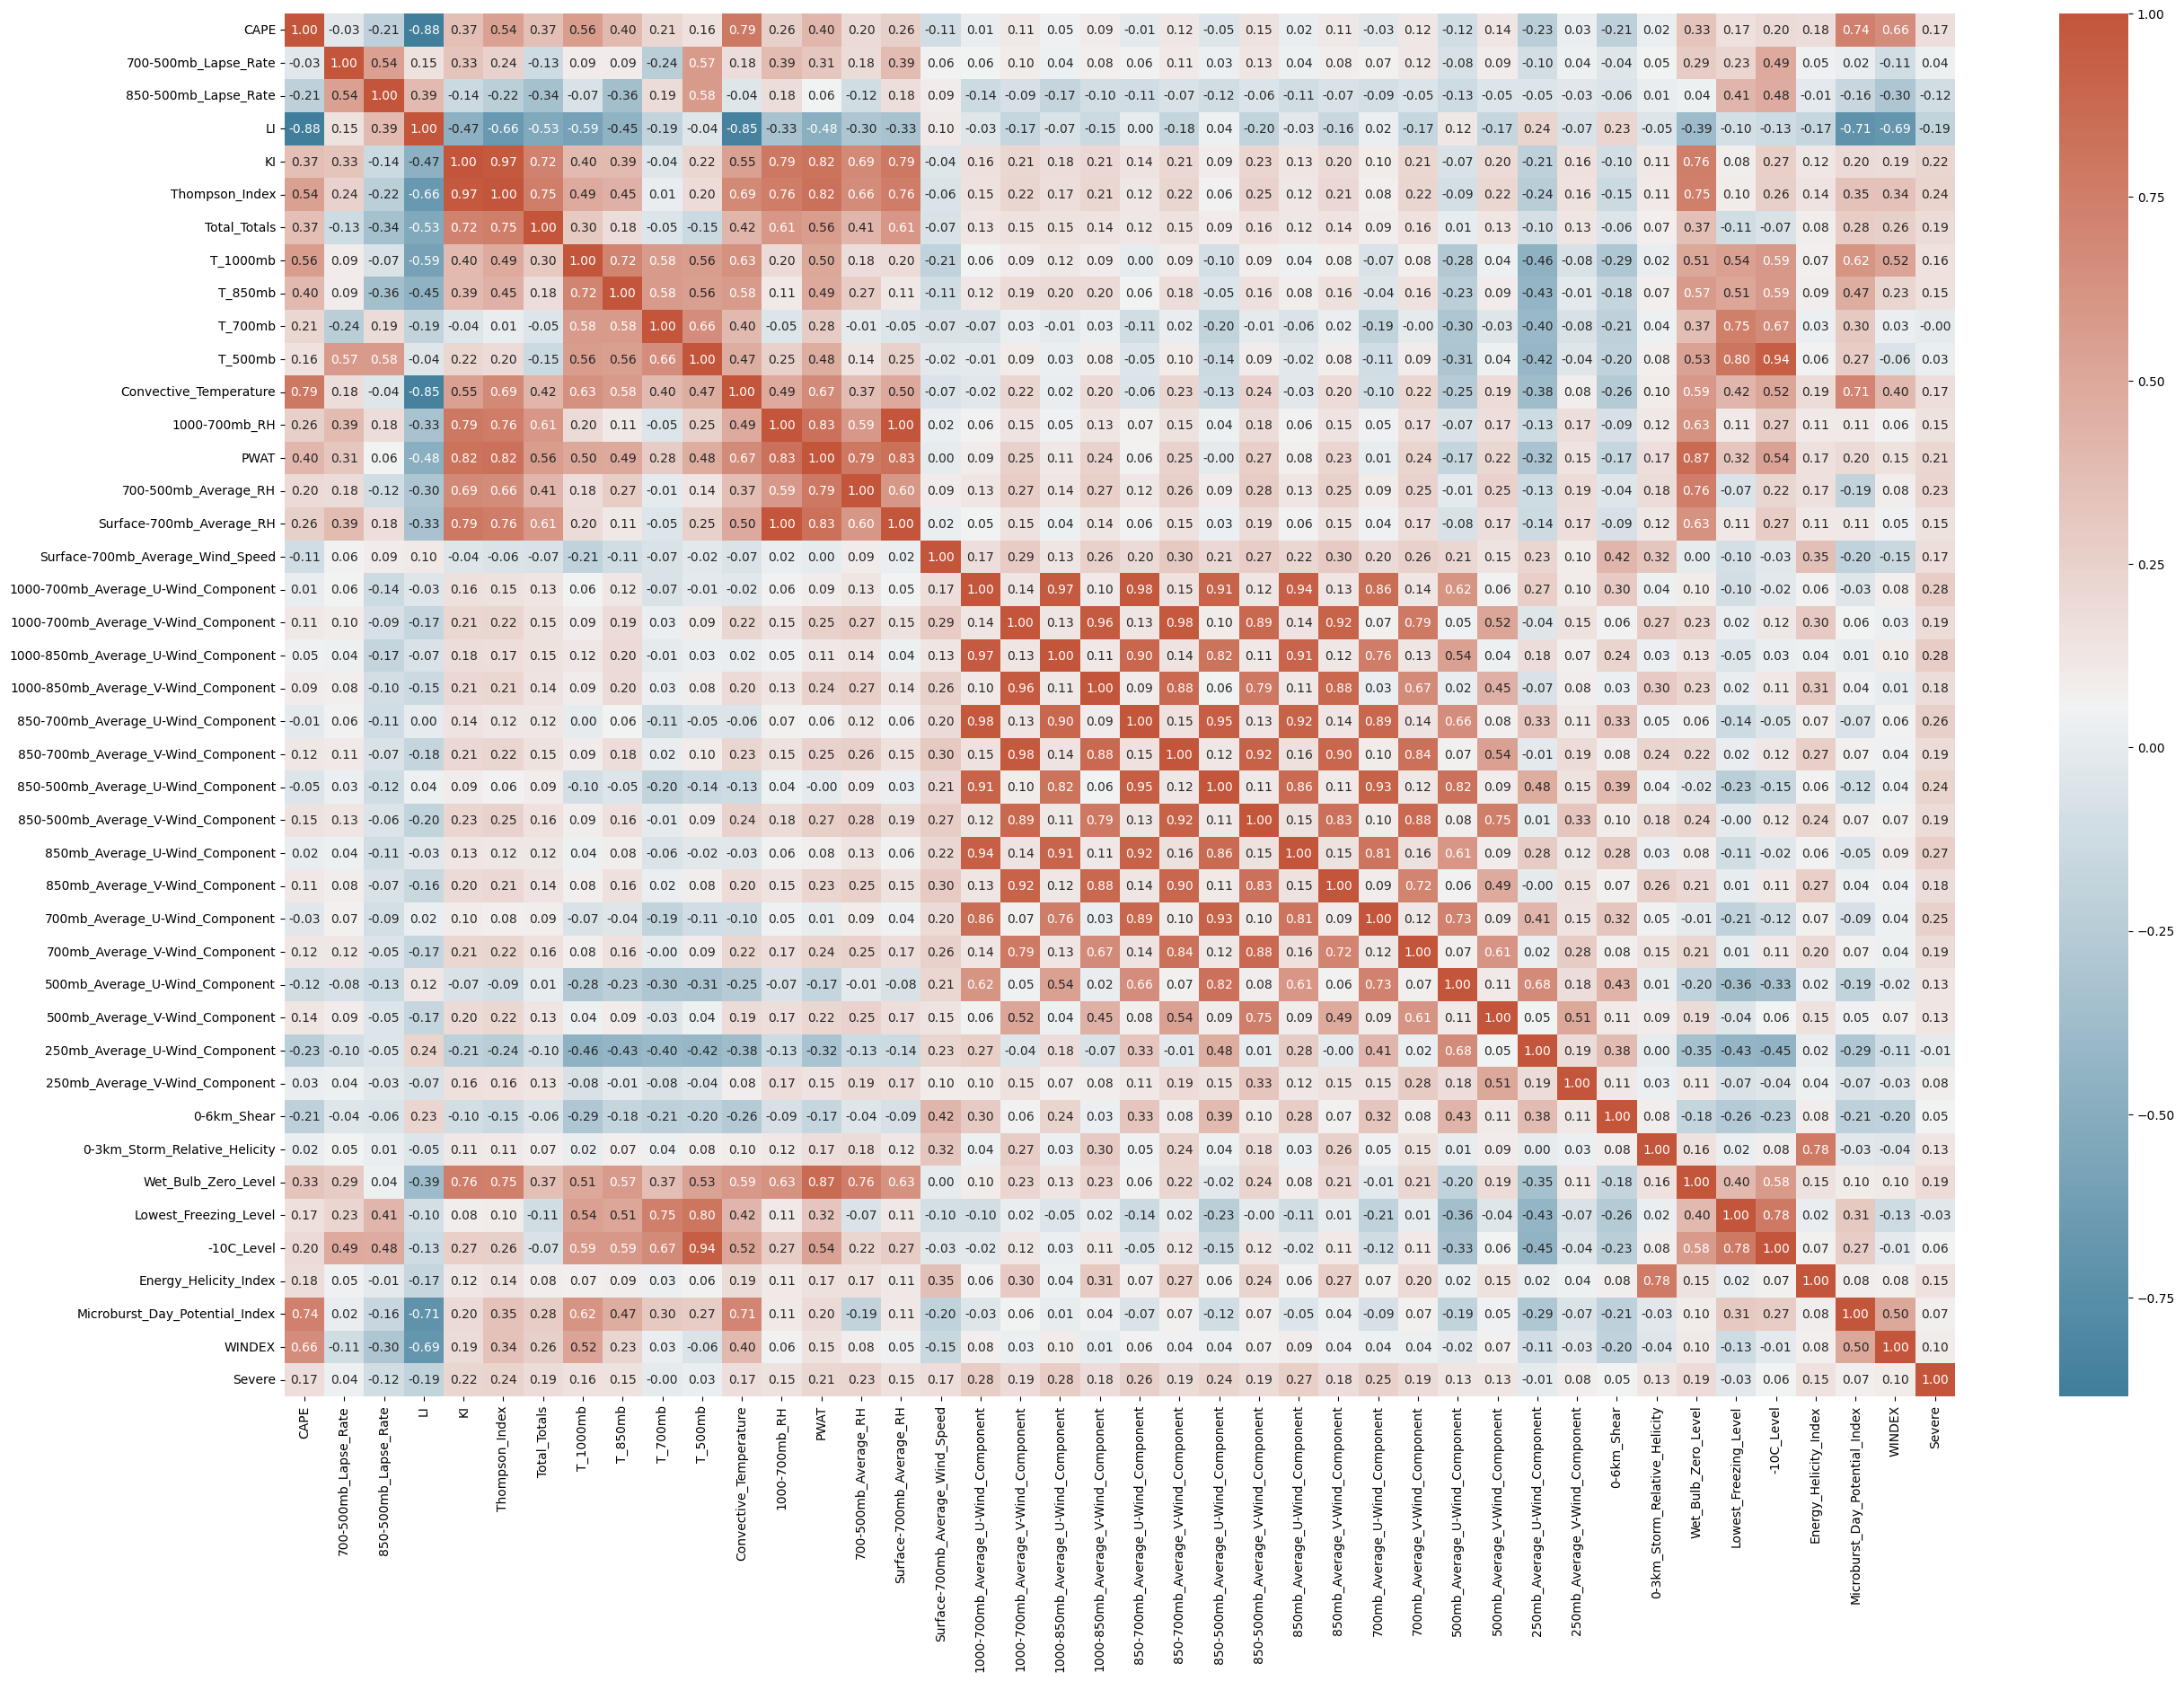

In [33]:
plt.figure(figsize=(30,20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df1.corr(),annot=True,fmt='.2f',cmap=cmap )
plt.show()

#Further Data Processing for Clustering

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Feature Scaling

In [25]:
# Scale features
scaler = StandardScaler()
severe_scaled = scaler.fit_transform(df_severe)
severe_scaled = pd.DataFrame(severe_scaled, columns=df_severe.columns)
severe_scaled.head()

,CAPE,700-500mb_Lapse_Rate,850-500mb_Lapse_Rate,LI,KI,Thompson_Index,Total_Totals,T_1000mb,T_850mb,T_700mb,T_500mb,Convective_Temperature,1000-700mb_RH,PWAT,700-500mb_Average_RH,Surface-700mb_Average_RH,Surface-700mb_Average_Wind_Speed,1000-700mb_Average_U-Wind_Component,1000-700mb_Average_V-Wind_Component,1000-850mb_Average_U-Wind_Component,1000-850mb_Average_V-Wind_Component,850-700mb_Average_U-Wind_Component,850-700mb_Average_V-Wind_Component,850-500mb_Average_U-Wind_Component,850-500mb_Average_V-Wind_Component,850mb_Average_U-Wind_Component,850mb_Average_V-Wind_Component,700mb_Average_U-Wind_Component,700mb_Average_V-Wind_Component,500mb_Average_U-Wind_Component,500mb_Average_V-Wind_Component,250mb_Average_U-Wind_Component,250mb_Average_V-Wind_Component,0-6km_Shear,0-3km_Storm_Relative_Helicity,Wet_Bulb_Zero_Level,Lowest_Freezing_Level,-10C_Level,Energy_Helicity_Index,Microburst_Day_Potential_Index,WINDEX,Severe
0,-0.327072,0.499311,0.612822,-0.077123,1.181859,1.062883,0.831855,0.613657,0.113076,0.332638,0.711037,0.368685,1.088441,0.513159,-0.435978,1.097808,-0.436760,0.383929,-0.906919,0.299204,-1.143028,0.453556,-0.673662,0.449982,-0.574948,-0.002610,-0.818308,0.619694,-0.441563,0.683187,0.049710,0.554658,-0.089147,0.704272,-0.280032,0.654362,-0.664715,0.371322,-0.291604,1.278909,0.542083,0.0
1,0.320526,0.608593,-0.176535,-0.825065,-0.114532,0.212514,-0.040754,0.347950,0.276841,-0.567959,0.071033,0.951649,-0.102215,-0.583092,-0.938975,-0.093893,0.192649,0.831391,-0.053597,0.767135,-0.173979,0.858042,0.058999,0.699172,0.145512,0.729857,-0.036542,0.905273,-0.248903,0.638211,-0.482478,0.821430,-0.933245,0.319401,-0.483393,-0.956324,-0.702819,-0.235850,-0.495569,1.578084,0.560554,0.0
2,-1.305344,-0.788270,-1.359847,0.857805,0.436434,0.056613,0.715507,0.082243,-0.050689,-0.868158,-1.336974,-2.097702,0.081796,-0.810885,-0.030150,0.028619,0.642226,1.155801,-0.015950,0.789961,-0.367789,1.411549,0.271707,1.479244,0.530585,0.820161,-0.002552,1.486280,-0.131165,1.843591,0.660741,2.411803,0.803185,2.253397,0.176157,-0.010310,-1.234735,-1.506536,-0.201480,-0.933405,0.231880,0.0
3,-0.839353,0.404889,-0.395019,0.296848,1.343908,1.062883,1.035464,-1.379146,-1.360810,-2.068954,-1.336974,-0.842087,1.965197,0.285366,0.695768,1.944250,-0.406788,0.260876,-0.254379,-0.465465,-0.639123,0.858042,0.058999,0.840018,0.070981,0.388708,-0.285801,0.491675,0.093606,0.566248,0.148263,2.006515,0.411282,0.705636,-0.488889,0.215715,-1.566689,-1.295184,-0.470972,-0.285405,0.244206,0.0
4,-0.928651,-0.665819,0.152368,0.184657,-0.390016,-0.411090,0.453725,0.082243,0.440606,1.233235,0.455035,0.278998,0.157565,0.684003,-0.218774,0.229092,-1.410845,-0.902526,-0.718686,-0.762202,-0.406551,-0.994079,-0.933638,-1.034322,-0.810961,-0.704974,-0.716339,-1.093784,-0.741258,-1.106893,-0.886547,-0.214878,-1.463820,-0.794098,-0.258047,-0.076527,0.716546,1.365348,-0.331440,0.741361,-0.158710,0.0


In [26]:
severe_scaled.drop(['Severe'], inplace=True, axis=1)

PCA

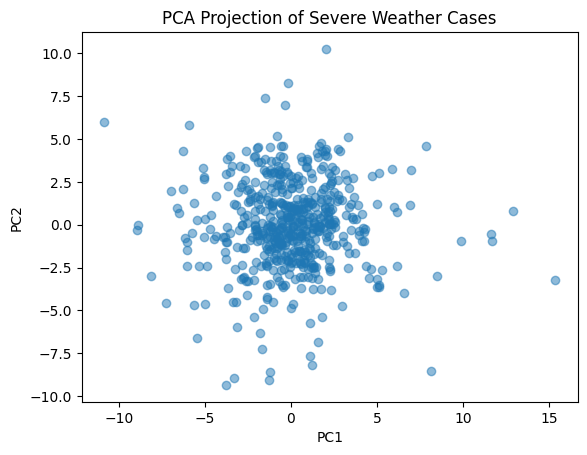

In [27]:
pca = PCA(n_components=2)
severe_pca = pca.fit_transform(severe_scaled)

plt.scatter(severe_pca[:, 0], severe_pca[:, 1], alpha=0.5)
plt.title("PCA Projection of Severe Weather Cases")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [28]:
pca = PCA(n_components=2)
pca.fit(severe_scaled)
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=severe_scaled.columns)
# Sort each component by absolute loading values
sorted_pc1 = loadings['PC1'].abs().sort_values(ascending=False)
sorted_pc2 = loadings['PC2'].abs().sort_values(ascending=False)

loadings

,PC1,PC2
CAPE,0.023683,0.022687
700-500mb_Lapse_Rate,0.071404,-0.161172
850-500mb_Lapse_Rate,0.032788,-0.243045
LI,-0.043345,-0.066402
KI,0.153317,-0.119460
...,...,...
Lowest_Freezing_Level,0.044776,-0.215798
-10C_Level,0.093516,-0.246074
Energy_Helicity_Index,0.153599,-0.014311
Microburst_Day_Potential_Index,-0.027521,0.062813


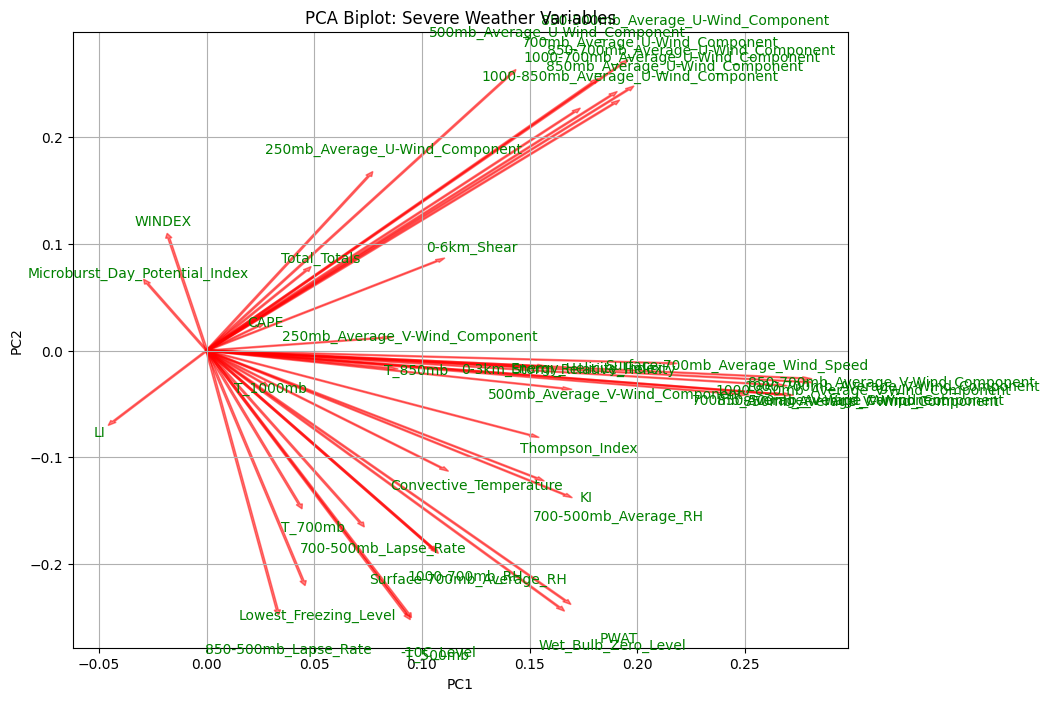

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for i, var in enumerate(severe_scaled.columns):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], color='r', alpha=0.5)
    plt.text(loadings.iloc[i, 0]*1.15, loadings.iloc[i, 1]*1.15, var, color='g', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.title('PCA Biplot: Severe Weather Variables')
plt.show()


# Model Building: Clustering

k=2: Inertia=20254.12
k=3: Inertia=18099.30
k=4: Inertia=17064.45
k=5: Inertia=16069.50
k=6: Inertia=15422.21
k=7: Inertia=14336.73
k=8: Inertia=13919.22
k=9: Inertia=13380.09
k=10: Inertia=12976.53


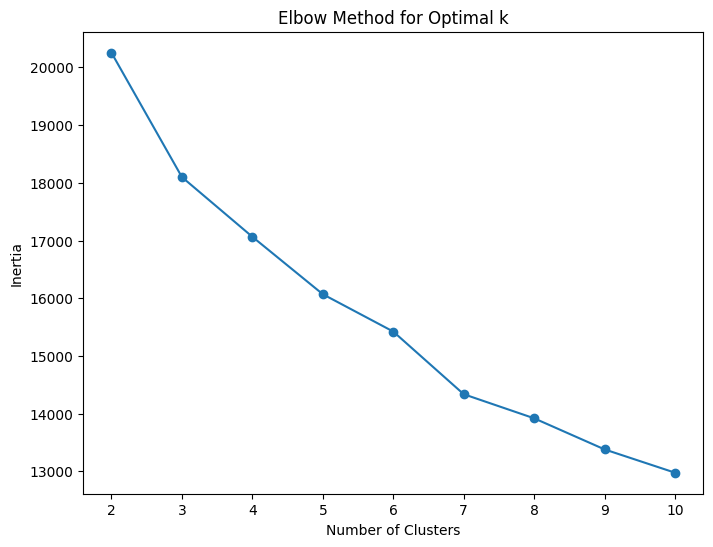

In [30]:
# Determine the optimal number of clusters using the Elbow method and Silhouette Score
inertia = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(severe_scaled)
    inertia.append(kmeans.inertia_)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}")

# Plot the elbow method result
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

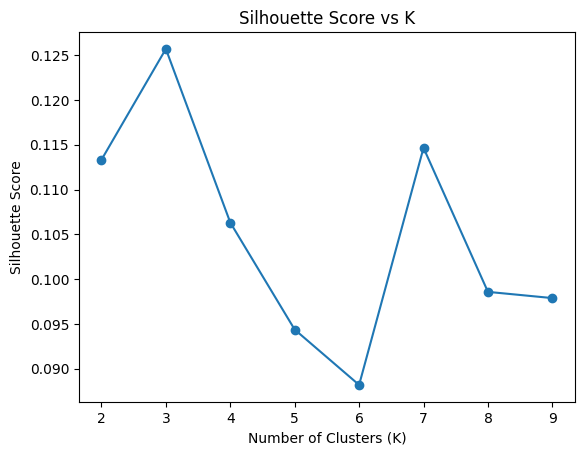

In [31]:
# Find optimal K using silhouette score
sil_scores = []
k_values = list(range(2, 10))
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(severe_scaled)
    sil = silhouette_score(severe_scaled, labels)
    sil_scores.append(sil)

plt.plot(k_values, sil_scores, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

Best K based on silhouette score: 3


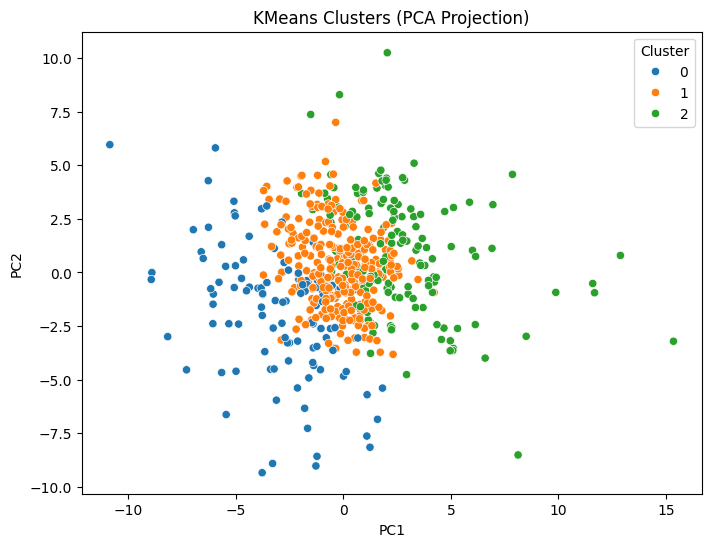

In [32]:
# Use best K
best_k = k_values[np.argmax(sil_scores)]
print("Best K based on silhouette score:", best_k)

# Final KMeans model
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(severe_scaled)

# Add cluster labels to DataFrame
clustered_df = pd.DataFrame(severe_scaled, columns=severe_scaled.columns)
clustered_df['Cluster'] = labels

# PCA visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=severe_pca[:, 0], y=severe_pca[:, 1], hue=labels, palette='tab10')
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.show()

In [ ]:
'''
cluster_profiles = clustered_df.groupby('Cluster').mean()
display(cluster_profiles)

# Visualize selected features by cluster
features_to_plot = ['CAPE', 'LI', '0-6km_Shear', 'PWAT', 'Energy_Helicity_Index', 'WINDEX', '700-500mb_Average_RH', 'Surface-700mb_Average_Wind_Speed']
for feature in features_to_plot:
    if feature in clustered_df.columns:
        plt.figure()
        sns.boxplot(x='Cluster', y=feature, data=clustered_df)
        plt.title(f"{feature} by Cluster")
        plt.show()
'''

,CAPE,700-500mb_Lapse_Rate,850-500mb_Lapse_Rate,LI,KI,Thompson_Index,Total_Totals,T_1000mb,T_850mb,T_700mb,T_500mb,Convective_Temperature,1000-700mb_RH,PWAT,700-500mb_Average_RH,Surface-700mb_Average_RH,Surface-700mb_Average_Wind_Speed,1000-700mb_Average_U-Wind_Component,1000-700mb_Average_V-Wind_Component,1000-850mb_Average_U-Wind_Component,1000-850mb_Average_V-Wind_Component,850-700mb_Average_U-Wind_Component,850-700mb_Average_V-Wind_Component,850-500mb_Average_U-Wind_Component,850-500mb_Average_V-Wind_Component,850mb_Average_U-Wind_Component,850mb_Average_V-Wind_Component,700mb_Average_U-Wind_Component,700mb_Average_V-Wind_Component,500mb_Average_U-Wind_Component,500mb_Average_V-Wind_Component,250mb_Average_U-Wind_Component,250mb_Average_V-Wind_Component,0-6km_Shear,0-3km_Storm_Relative_Helicity,Wet_Bulb_Zero_Level,Lowest_Freezing_Level,-10C_Level,Energy_Helicity_Index,Microburst_Day_Potential_Index,WINDEX
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.594658,0.077946,0.357842,0.713706,-0.434914,-0.650857,-0.362845,-0.617371,-0.668189,-0.242973,-0.133298,-0.604705,-0.019097,-0.321209,-0.224332,-0.007144,-0.151065,-1.345575,-0.532526,-1.293062,-0.467954,-1.345734,-0.565031,-1.320090,-0.521956,-1.310223,-0.529447,-1.197229,-0.470335,-0.957190,-0.280760,-0.339369,-0.092189,-0.199107,-0.093437,-0.266243,-0.017068,-0.141331,-0.158956,-0.462217,-0.557314
1,0.493862,-0.117213,-0.121922,-0.468294,0.045202,0.217008,0.112080,0.558108,0.377839,0.305442,0.151312,0.391185,-0.090033,0.057227,-0.169601,-0.100839,-0.361569,0.227862,-0.254991,0.255818,-0.266224,0.198647,-0.237293,0.157417,-0.232767,0.214638,-0.255680,0.132222,-0.214480,0.058338,-0.190286,-0.114025,-0.180174,-0.250307,-0.234645,0.032332,0.177808,0.177057,-0.159820,0.489310,0.450223
2,-0.512804,0.167627,-0.026755,0.377377,0.229552,0.057747,0.049222,-0.619224,-0.237381,-0.407853,-0.192648,-0.309048,0.186140,0.123918,0.487519,0.198130,0.801577,0.541808,0.874851,0.450159,0.849422,0.597822,0.864611,0.658074,0.824648,0.541422,0.873932,0.617002,0.752149,0.583938,0.568101,0.464776,0.411724,0.623606,0.516851,0.131609,-0.327803,-0.236069,0.421298,-0.600334,-0.456445


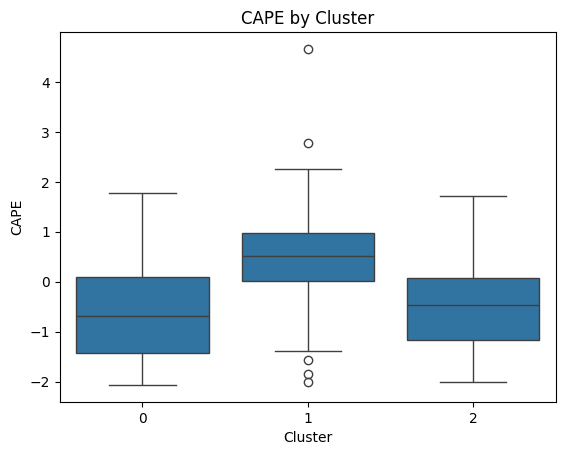

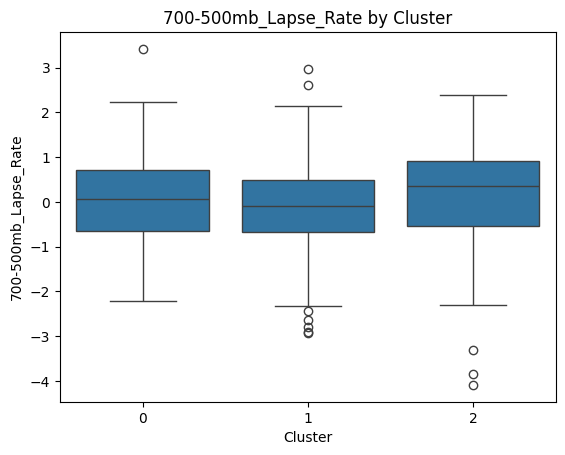

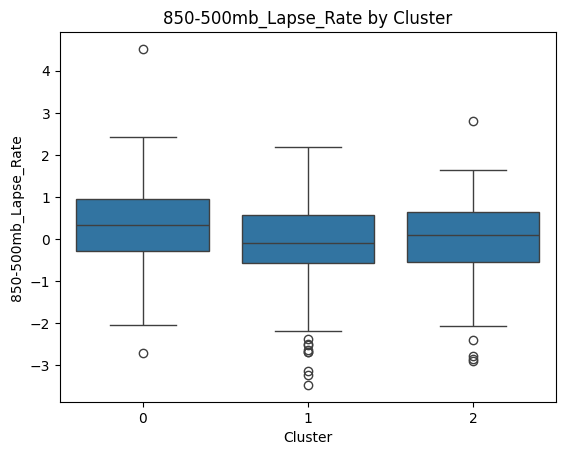

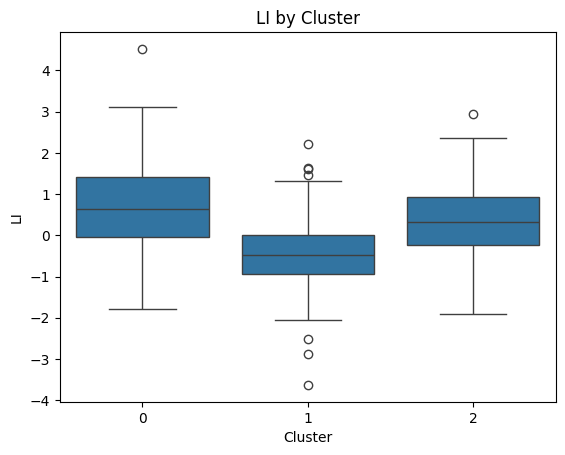

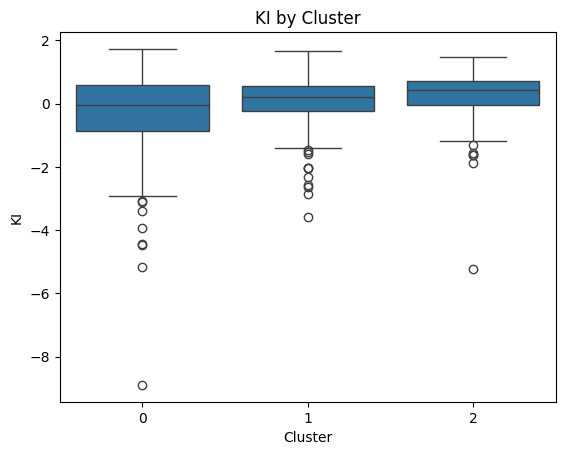

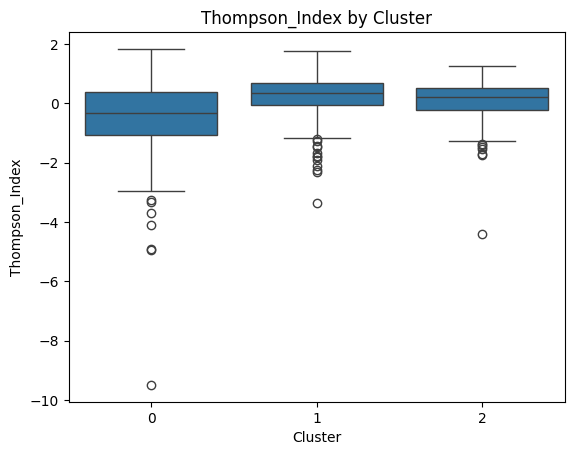

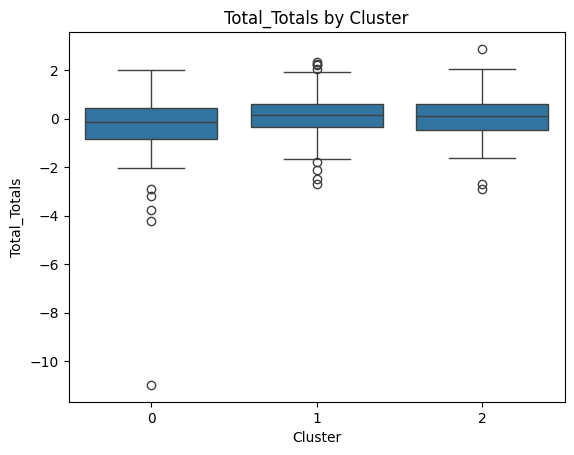

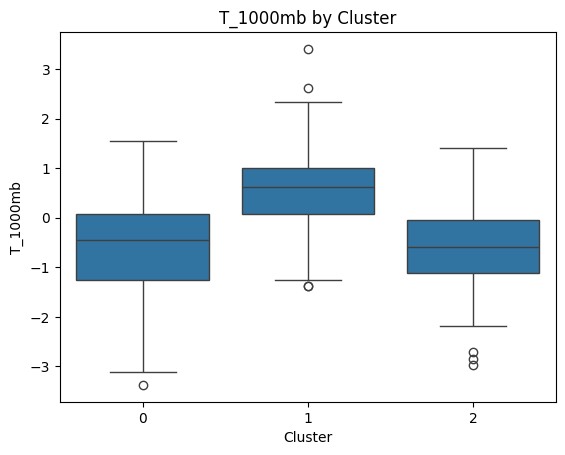

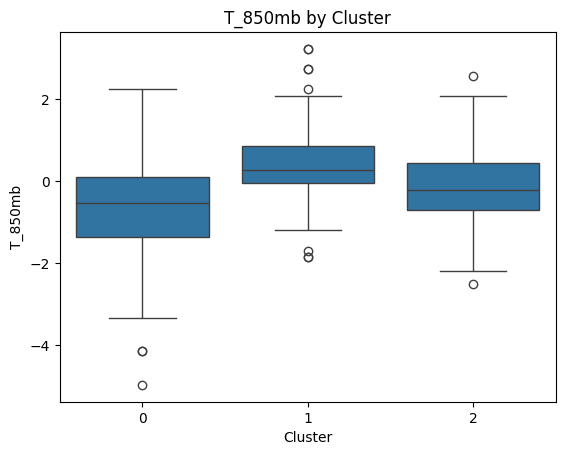

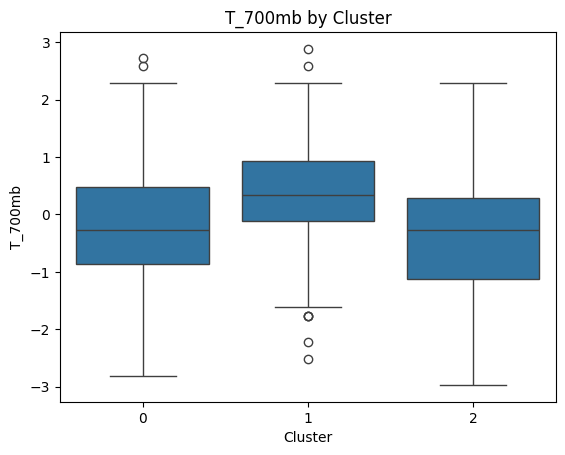

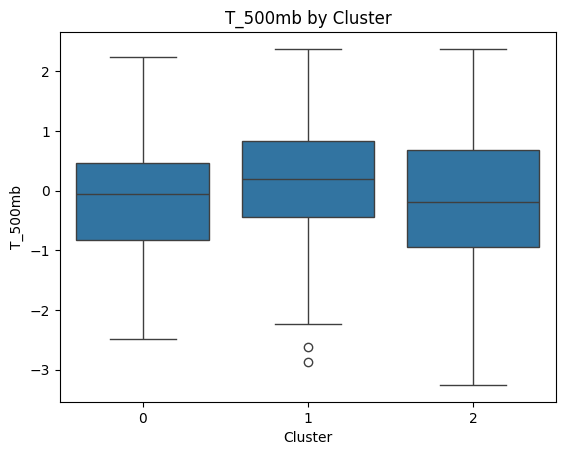

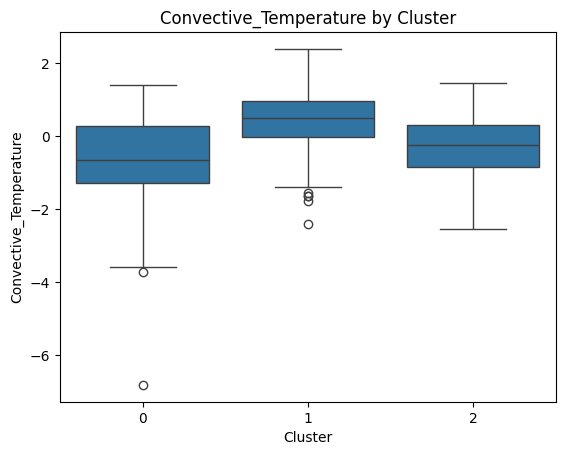

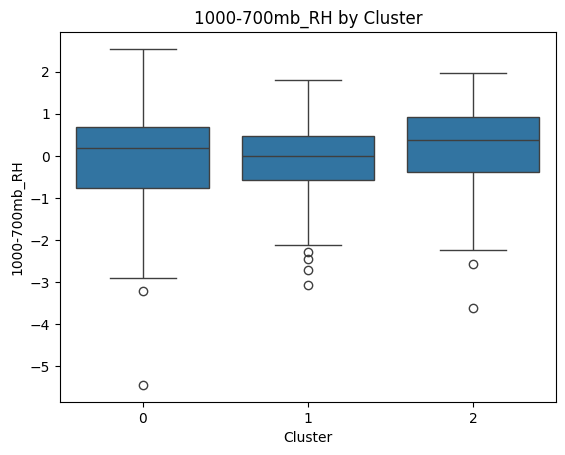

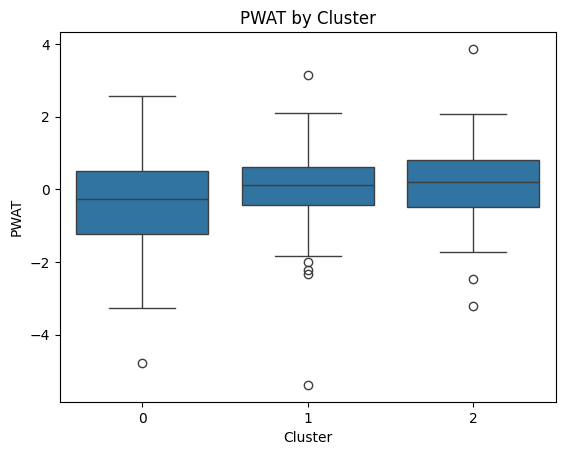

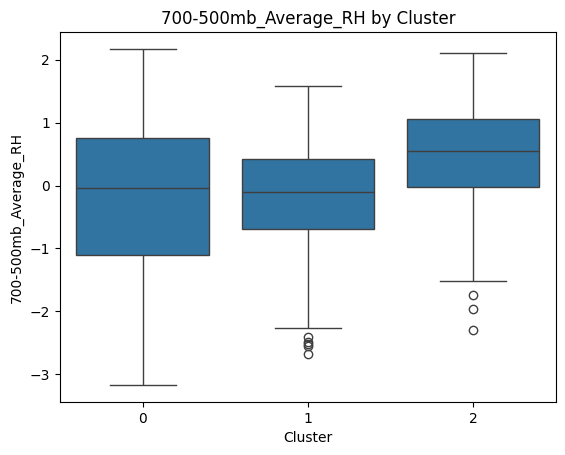

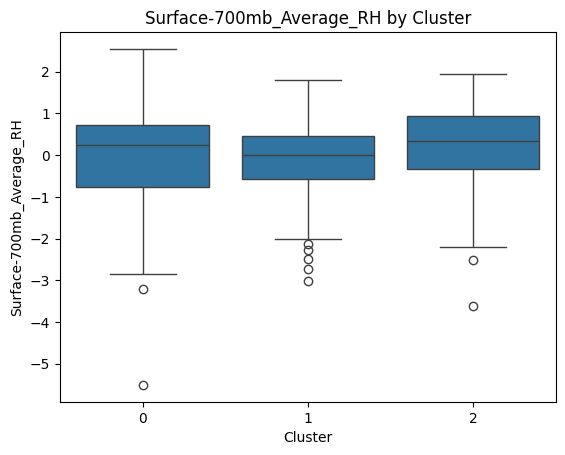

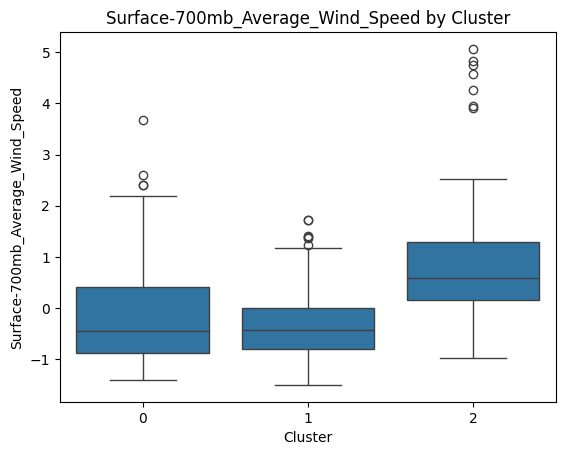

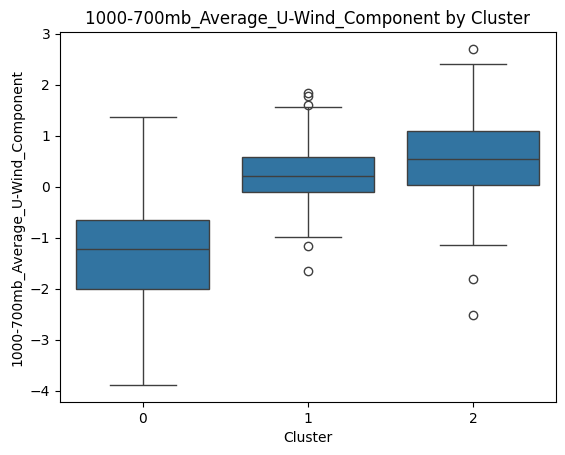

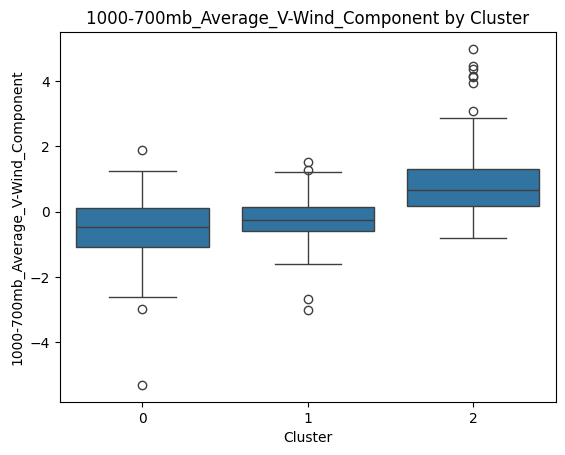

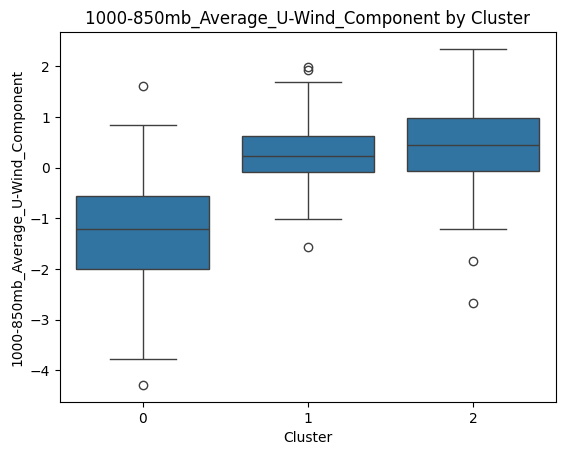

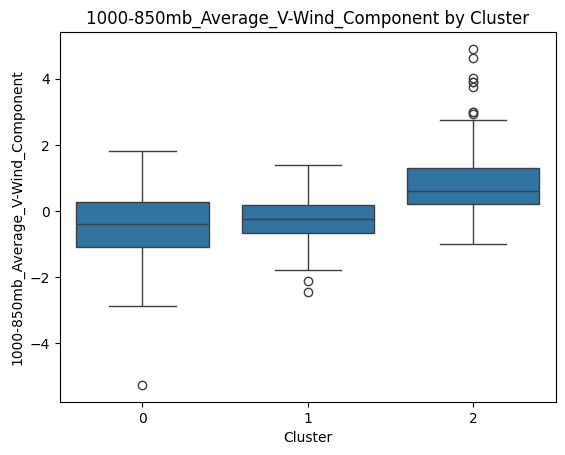

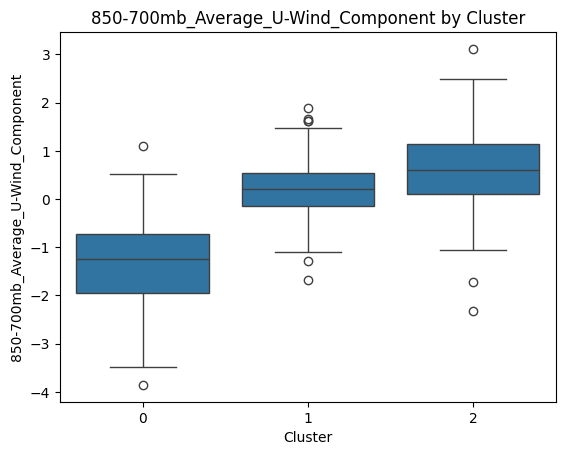

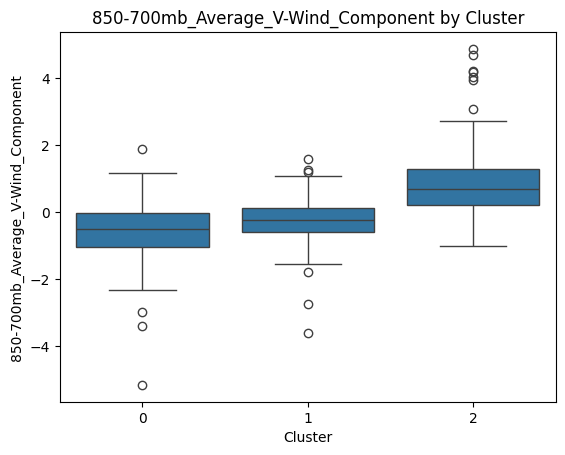

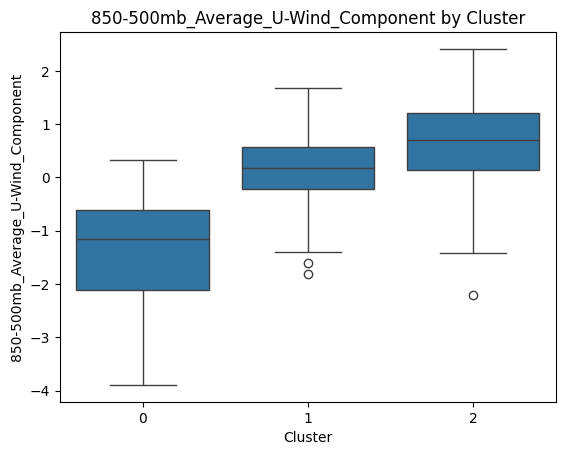

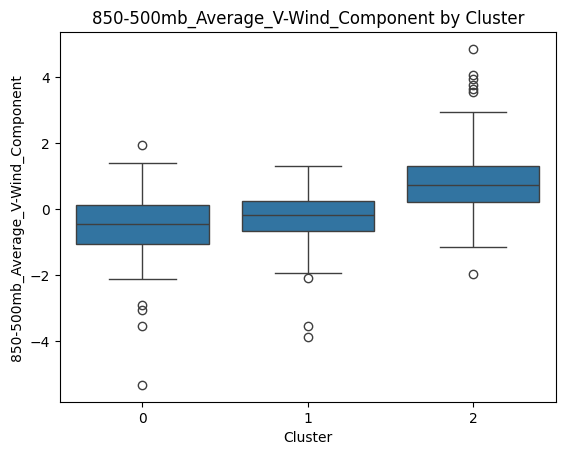

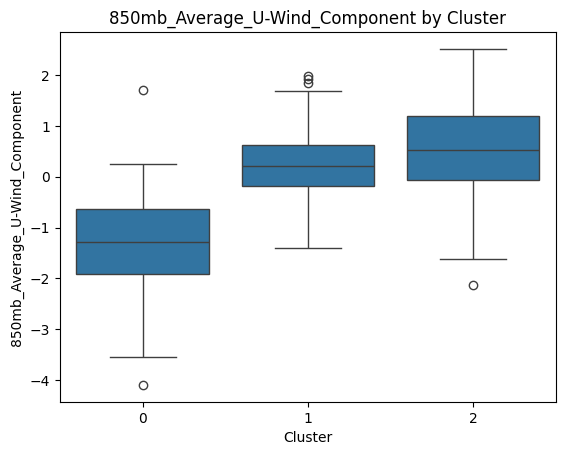

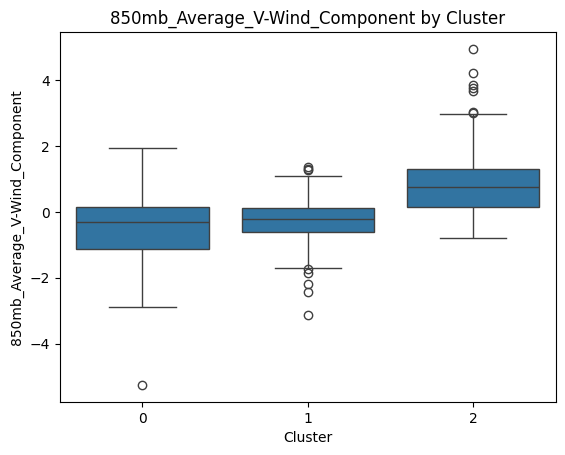

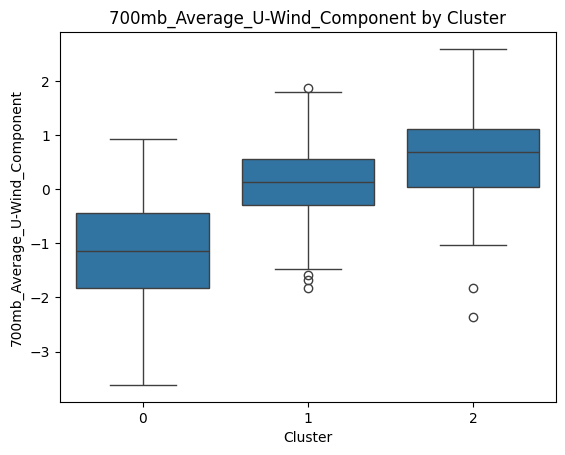

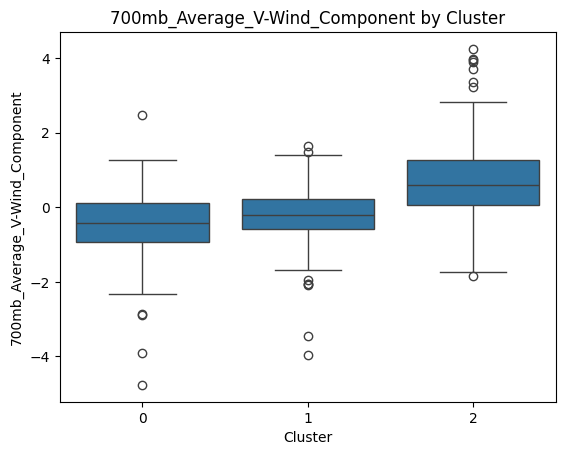

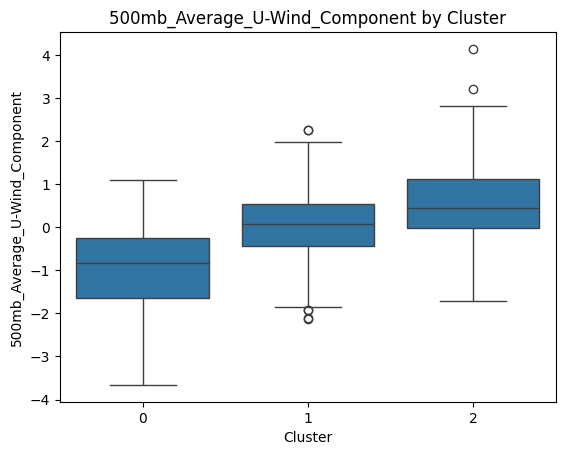

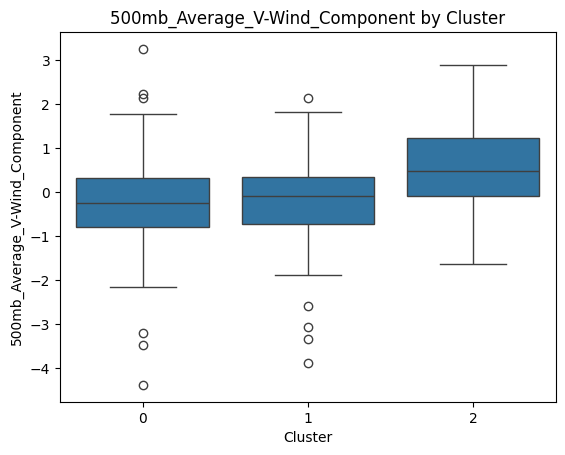

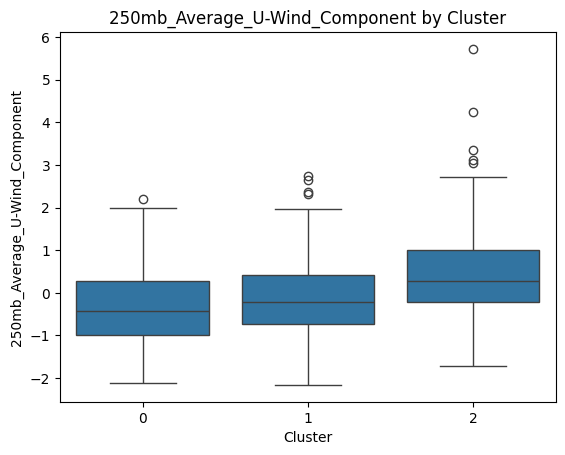

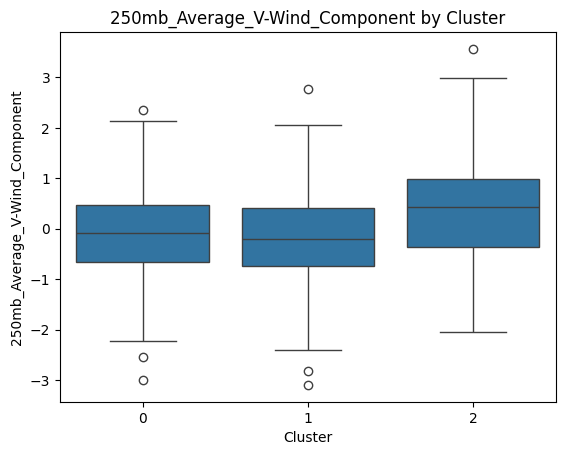

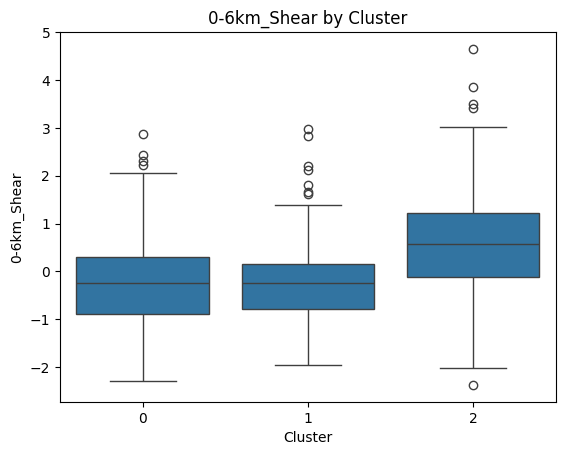

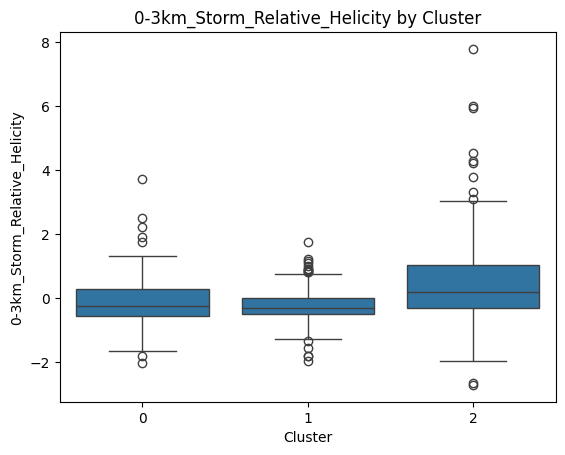

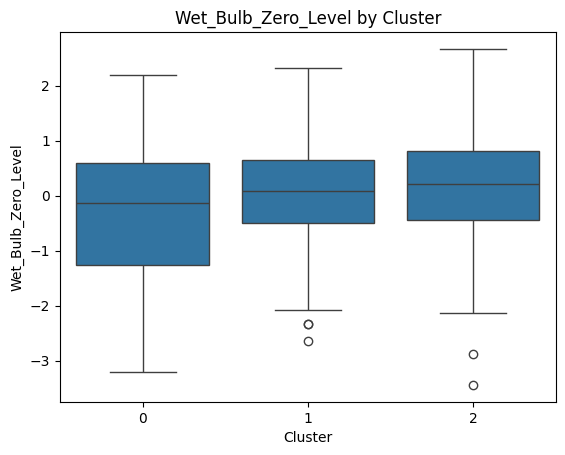

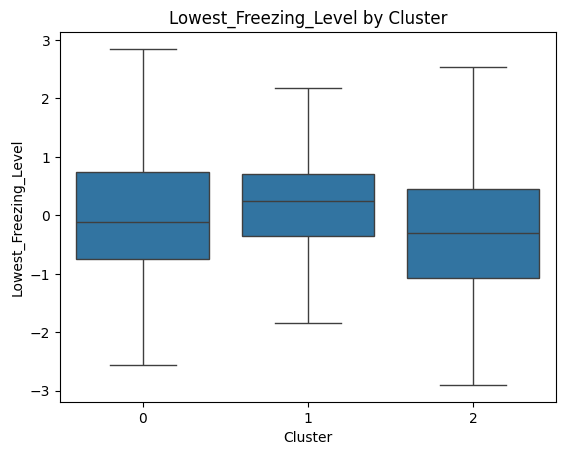

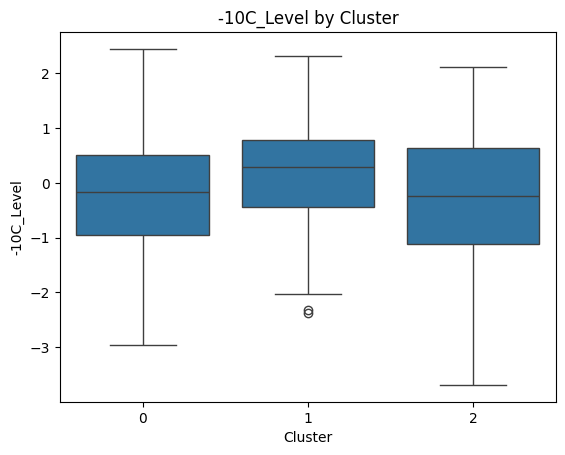

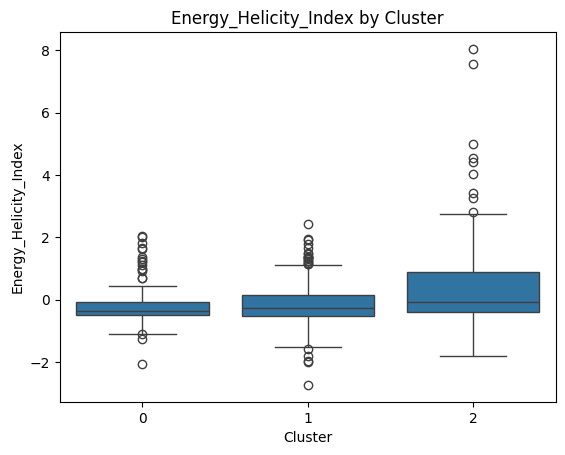

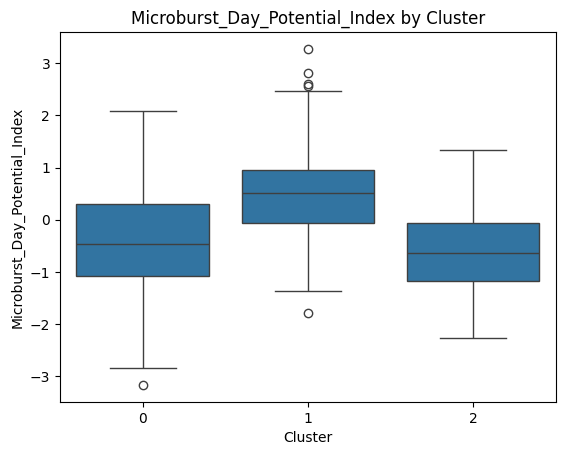

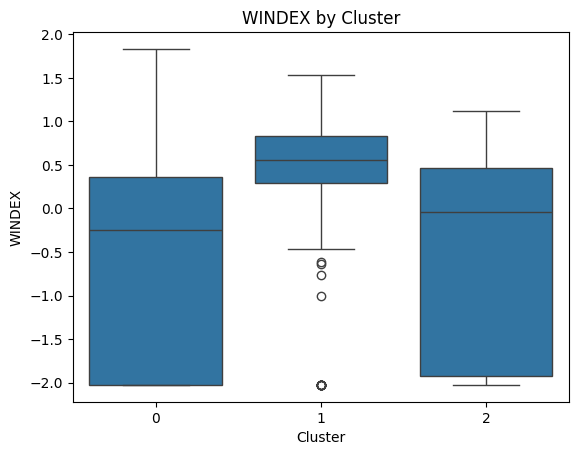

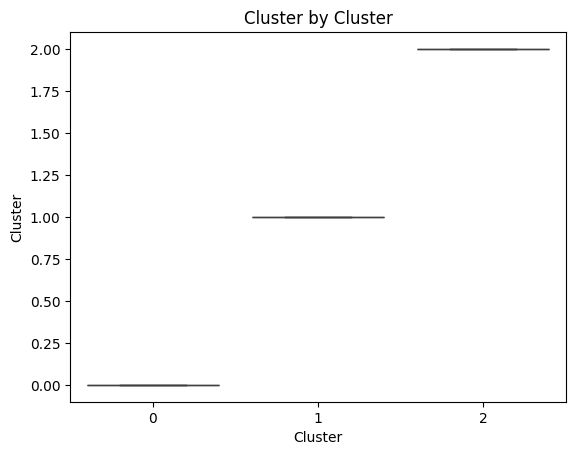

In [38]:
cluster_profiles = clustered_df.groupby('Cluster').mean()
display(cluster_profiles)

# Visualize selected features by cluster
features_to_plot = ['CAPE', 'LI', '0-6km_Shear', 'PWAT', 'Energy_Helicity_Index', 'WINDEX', '700-500mb_Average_RH', 'Surface-700mb_Average_Wind_Speed']
for feature in clustered_df.columns:
      plt.figure()
      sns.boxplot(x='Cluster', y=feature, data=clustered_df)
      plt.title(f"{feature} by Cluster")
      plt.show()

In [36]:
# Let's add example environments (rows) for each cluster using the original scaled data and labels
# Re-create the final cluster labels using best_k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(severe_scaled)

# Add cluster labels to the original unscaled severe data
severe_examples = df_severe.copy()
severe_examples['Cluster'] = labels

# Pick a few representative examples from each cluster (closest to cluster centroids)
import numpy as np
from scipy.spatial.distance import cdist

centroids = kmeans.cluster_centers_
distances = cdist(severe_scaled, centroids)
closest_indices = [np.argmin(distances[:, i]) for i in range(3)]

example_envs = severe_examples.iloc[closest_indices]
example_envs.reset_index(drop=True, inplace=True)
example_envs

,CAPE,700-500mb_Lapse_Rate,850-500mb_Lapse_Rate,LI,KI,Thompson_Index,Total_Totals,T_1000mb,T_850mb,T_700mb,T_500mb,Convective_Temperature,1000-700mb_RH,PWAT,700-500mb_Average_RH,Surface-700mb_Average_RH,Surface-700mb_Average_Wind_Speed,1000-700mb_Average_U-Wind_Component,1000-700mb_Average_V-Wind_Component,1000-850mb_Average_U-Wind_Component,1000-850mb_Average_V-Wind_Component,850-700mb_Average_U-Wind_Component,850-700mb_Average_V-Wind_Component,850-500mb_Average_U-Wind_Component,850-500mb_Average_V-Wind_Component,850mb_Average_U-Wind_Component,850mb_Average_V-Wind_Component,700mb_Average_U-Wind_Component,700mb_Average_V-Wind_Component,500mb_Average_U-Wind_Component,500mb_Average_V-Wind_Component,250mb_Average_U-Wind_Component,250mb_Average_V-Wind_Component,0-6km_Shear,0-3km_Storm_Relative_Helicity,Wet_Bulb_Zero_Level,Lowest_Freezing_Level,-10C_Level,Energy_Helicity_Index,Microburst_Day_Potential_Index,WINDEX,Severe,Cluster
0,1682.498063,-0.001750,-0.001656,-4.5,24.3,28.8,41.0,26.2,15.8,7.8,-7.7,20.9,59.7,1.720469,77.0,59.9,7.0,-6.7,1.3,-8.6,2.8,-5.1,0.0,-1.7,1.2,-7.8,1.4,-0.9,-0.2,7.2,7.2,15.7,9.0,2.613850,-1.8,13962.8,15001.77391,20720.14502,-0.018928,0.519571,12.700844,1,0
1,3177.199837,-0.001683,-0.001779,-7.7,30.5,38.2,43.6,27.8,18.2,7.8,-7.1,23.6,64.7,1.748028,59.7,64.6,8.3,6.7,4.9,6.2,4.9,7.1,4.9,10.1,5.8,10.9,5.1,18.8,6.8,10.4,6.0,7.7,4.5,15.492405,5.8,12949.0,14865.99078,21477.00957,0.115173,1.076738,15.199058,1,1
2,2438.563658,-0.001637,-0.001753,-6.4,32.2,38.6,43.8,24.2,17.2,6.8,-7.7,23.7,69.1,1.889760,79.1,69.8,18.3,13.0,13.3,7.6,11.7,17.7,14.7,18.5,14.6,9.1,13.1,22.1,15.5,11.0,19.0,14.1,16.8,29.099285,54.5,13790.1,14561.09700,20647.65107,0.830636,0.812172,10.731767,1,2


#Discussion

This analysis identified 3 distinct regimes. After analyzing each one, I have interpreted them meteorologically:



**Cluster 0: "Cooler, Stable Regime with Weak Instability"**
Low CAPE (-0.59) and weak lapse rates → limited instability

*   Low temps at 1000mb, 850mb → cooler surface environment

*   Low KI, TT, and Thompson Index → supports a more stable profile
*   Negative values for WINDEX and MDPI → low microburst and wind gust potential


*   Winds aloft (U- and V-components) slightly weaker
*  This is likely the regime in May severe storms before we get into the heart of the summer season




**Interpretation:**
This cluster likely represents cooler post-frontal or marginally supportive environments, where severe weather is possible but not strongly driven by instability or dry microbursts. Possibly elevated convection.

**Cluster 1: "Moist, Unstable Pulse-Storm Regime"**


*   Above-average CAPE (+0.49) with warm surface temps (1000mb, 850mb)
*   Positive KI, TT, and MDPI → favors warm-season, moist convection


*   Weak shear and SRH → likely poorly organized convection
*   Positive PWAT and wet-bulb zero height → high moisture, less favorable for hail






**Interpretation:**
Classic southeastern U.S. summer regime or airmass thunderstorms — warm, moist, unstable conditions but not enough shear to organize storms. Good chance for pulse storms, downbursts, and locally heavy rain.



**Cluster 2: "Sheared, Dynamically Driven Regime"**
* Lower CAPE, but...Strong shear (+0.62) and higher SRH

* Positive Energy Helicity Index (+0.42) → favors supercells or organized convection

* Cooler surface temps but enhanced upper-level winds

* Negative MDPI and WINDEX → less microburst-driven, more rotational/dynamic support

**Interpretation:**
This is a dynamically forced regime — likely tied to synoptic-scale systems, fronts, or shortwaves. Think ssetups with moderate instability and strong kinematics — good potential for supercells or rotating storms.